In [90]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [91]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [92]:
%store -r

In [56]:
import time
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


class RandomForestMSE:
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.random_state = None

        self.tree_list = []
        self.feature_subset_list = []

        for param, value in trees_parameters.items():
            self.__setattr__(param, value)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects

        returns: dict
            Dictionary with time and rmse loss on iterations
        """
        np.random.seed(self.random_state)

        self.tree_list = []
        self.feature_subset_list = []

        if self.feature_subsample_size is None:
            self.feature_subsample_size = 1 / 3

        history = {'predict_train': [0], 'predict_val': [0], 'rmse_train': [], 'rmse_val': [], 'time': []}
        start_time = time.time()

        for k in range(self.n_estimators):
            bag = np.random.choice(X.shape[0], X.shape[0], replace=True)
            feature = np.random.choice(X.shape[1], int(X.shape[1] * self.feature_subsample_size), replace=False)

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X[bag][:, feature], y[bag])

            self.tree_list.append(tree)
            self.feature_subset_list.append(feature)

            history['predict_train'][0] = (history['predict_train'][0] * k + tree.predict(X[:, feature])) / (k + 1)
            history['rmse_train'].append(mean_squared_error(y, history['predict_train'][0], squared=False))
            history['time'].append(time.time() - start_time)
            if X_val is not None and y_val is not None:
                history['predict_val'][0] = (history['predict_val'][0] * k + tree.predict(X_val[:, feature])) / (k + 1)
                history['rmse_val'].append(mean_squared_error(y_val, history['predict_val'][0], squared=False))

        return history

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        tree_count = len(self.tree_list)
        if tree_count == 0:
            raise RuntimeError('Unable to predict: model isn\'t fitted')

        prediction = np.zeros(X.shape[0])

        for tree, feature_subset in zip(self.tree_list, self.feature_subset_list):
            prediction += tree.predict(X[:, feature_subset])

        return prediction / tree_count


class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.random_state = None

        self.tree_list = []
        self.alpha_list = []
        self.feature_subset_list = []

        for param, value in trees_parameters.items():
            self.__setattr__(param, value)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        returns: dict
            Dictionary with time and rmse loss on iterations
        """
        np.random.seed(self.random_state)

        self.tree_list = []
        self.alpha_list = []
        self.feature_subset_list = []

        if self.feature_subsample_size is None:
            self.feature_subsample_size = 1 / 3

        history = {'predict_val': [0], 'rmse_train': [], 'rmse_val': [], 'time': []}
        start_time = time.time()

        y_pred = np.zeros_like(y)

        for _ in range(self.n_estimators):
            antigrad = 2 * (y - y_pred)
            feature = np.random.choice(X.shape[1], int(X.shape[1] * self.feature_subsample_size), replace=False)

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X[:, feature], antigrad)
            tree_pred = tree.predict(X[:, feature])

            alpha = minimize_scalar(lambda x, tp=tree_pred, yp=y_pred: mean_squared_error(y, yp + x * tp)).x

            self.tree_list.append(tree)
            self.alpha_list.append(alpha)
            self.feature_subset_list.append(feature)

            y_pred = y_pred + alpha * self.learning_rate * tree_pred

            history['time'].append(time.time() - start_time)
            history['rmse_train'].append(mean_squared_error(y, y_pred, squared=False))
            if X_val is not None and y_val is not None:
                history['predict_val'][0] += (alpha * self.learning_rate * tree.predict(X_val[:, feature]))
                history['rmse_val'].append(mean_squared_error(y_val, history['predict_val'][0], squared=False))

        return history

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        if len(self.tree_list) == 0:
            raise RuntimeError('Unable to predict: model isn\'t fitted')
        prediction = np.zeros(X.shape[0])

        for tree, feature_subset, alpha in zip(self.tree_list, self.feature_subset_list, self.alpha_list):
            prediction += alpha * self.learning_rate * tree.predict(X[:, feature_subset])

        return prediction


## Эксперимент 1

In [131]:
X = pd.read_csv('kc_house_data.csv')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [132]:
y = X.price
X['date'] = pd.to_datetime(X['date'])
X['day'] = X['date'].dt.day
X['month'] = X['date'].dt.month
X['year'] = X['date'].dt.year
X = X.drop(['id', 'price', 'date'], axis=1)
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day,month,year
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,13,10,2014
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,9,12,2014
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,25,2,2015
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,9,12,2014
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,18,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,2009,0,98103,47.6993,-122.346,1530,1509,21,5,2014
21609,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,2014,0,98146,47.5107,-122.362,1830,7200,23,2,2015
21610,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,2009,0,98144,47.5944,-122.299,1020,2007,23,6,2014
21611,3,2.50,1600,2388,2.0,0,0,3,8,1600,...,2004,0,98027,47.5345,-122.069,1410,1287,16,1,2015


In [133]:
X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Эксперимент 2

In [17]:
%store hist

Stored 'hist' (dict)


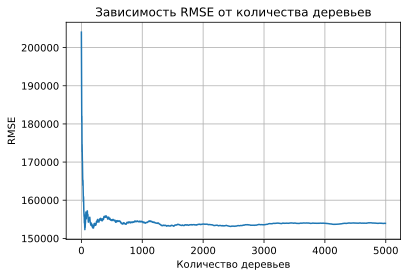

In [94]:
plt.plot(np.arange(4995), hist['rmse'][5:])
plt.grid()
plt.title('Зависимость RMSE от количества деревьев')
plt.ylabel('RMSE')
plt.xlabel('Количество деревьев')
plt.savefig('pdf/rf_5000.pdf', bbox_inches='tight')

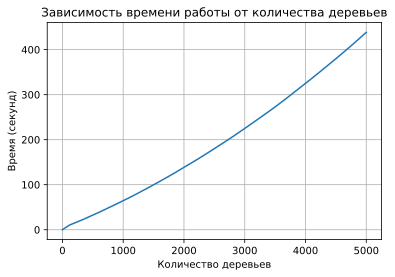

In [95]:
plt.plot(np.arange(5000), hist['time'])
plt.grid()
plt.title('Зависимость времени работы от количества деревьев')
plt.ylabel('Время (секунд)')
plt.xlabel('Количество деревьев')
plt.savefig('pdf/rf_5000_time.pdf', bbox_inches='tight')

In [8]:
feature_subsample = [0.1, 0.3, 0.5, 0.7, 1.0]
max_depth = [1, 4, 7, 10, 13, 16, None]
# 35 combinations

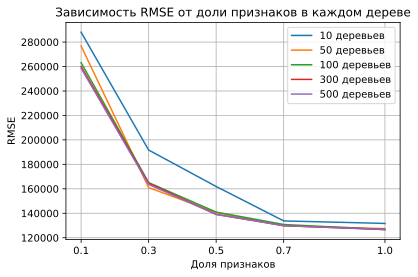

In [152]:
num_trees = [10, 50, 100, 300, 500]
for n in num_trees:
    t = []
    for feat in feature_subsample:
        t.append(hyper_history[None, feat]['rmse'][n - 1])
    plt.plot(feature_subsample, t, label=f'{n} деревьев')
plt.grid()
plt.title('Зависимость RMSE от доли признаков в каждом дереве')
plt.legend()
plt.xticks(feature_subsample)
plt.ylabel('RMSE')
plt.xlabel('Доля признаков')
plt.savefig('pdf/rf_feat_rmse.pdf', bbox_inches='tight')

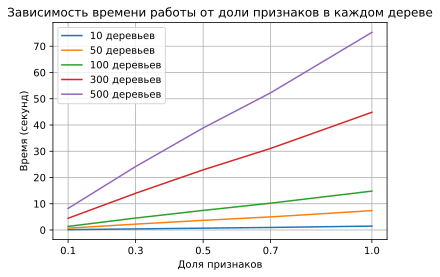

In [97]:
num_trees = [10, 50, 100, 300, 500]
for n in num_trees:
    t = []
    for feat in feature_subsample:
        t.append(hyper_history[None, feat]['time'][n - 1])
    plt.plot(feature_subsample, t, label=f'{n} деревьев')
plt.grid()
plt.title('Зависимость времени работы от доли признаков в каждом дереве')
plt.legend()
plt.xticks(feature_subsample)
plt.ylabel('Время (секунд)')
plt.xlabel('Доля признаков')
plt.savefig('pdf/rf_feat_time.pdf', bbox_inches='tight')

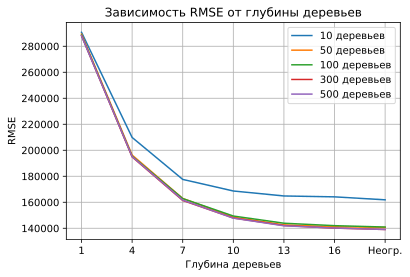

In [137]:
num_trees = [10, 50, 100, 300, 500]
for n in num_trees:
    t = []
    for depth in max_depth:
        t.append(hyper_history[depth, 0.5]['rmse'][n - 1])
    plt.plot(max_depth[:-1] + [19], t, label=f'{n} деревьев')
plt.grid()
plt.xticks(max_depth[:-1] + [19], labels=max_depth[:-1] + ['Неогр.'])
plt.title('Зависимость RMSE от глубины деревьев')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Глубина деревьев')
plt.savefig('pdf/rf_depth_rmse.pdf', bbox_inches='tight')

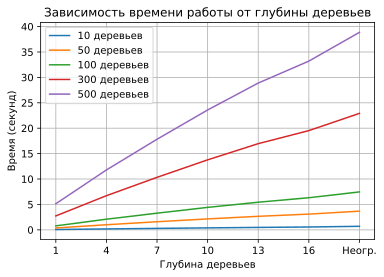

In [139]:
num_trees = [10, 50, 100, 300, 500]
for n in num_trees:
    t = []
    for depth in max_depth:
        t.append(hyper_history[depth, 0.5]['time'][n - 1])
    plt.plot(max_depth[:-1] + [19], t, label=f'{n} деревьев')
plt.grid()
plt.xticks(max_depth[:-1] + [19], labels=max_depth[:-1] + ['Неогр.'])
plt.title('Зависимость времени работы от глубины деревьев')
plt.legend()
plt.ylabel('Время (секунд)')
plt.xlabel('Глубина деревьев')
plt.savefig('pdf/rf_depth_time.pdf', bbox_inches='tight')

## Эксперимент 3

In [18]:
%store hist_gb

Stored 'hist_gb' (dict)


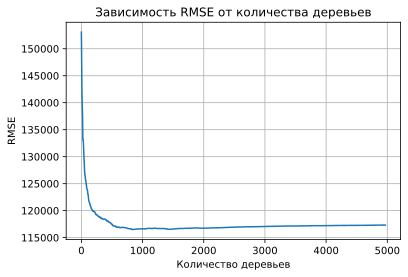

In [100]:
plt.plot(np.arange(4970), hist_gb['rmse'][30:])
plt.grid()
plt.title('Зависимость RMSE от количества деревьев')
plt.ylabel('RMSE')
plt.xlabel('Количество деревьев')
plt.savefig('pdf/gb_5000.pdf', bbox_inches='tight')

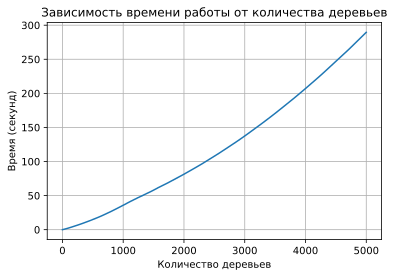

In [101]:
plt.plot(np.arange(5000), hist_gb['time'])
plt.grid()
plt.title('Зависимость времени работы от количества деревьев')
plt.ylabel('Время (секунд)')
plt.xlabel('Количество деревьев')
plt.savefig('pdf/gb_5000_time.pdf', bbox_inches='tight')

In [54]:
feature_subsample = [0.1, 0.3, 0.5, 0.7, 1.0]
max_depth = [1, 4, 7, 10, 13, 16, None]
learning_rate = np.logspace(-3, 0, 4)
# 140 combinations

In [113]:
%store hyper_history_gb

Stored 'hyper_history_gb' (dict)


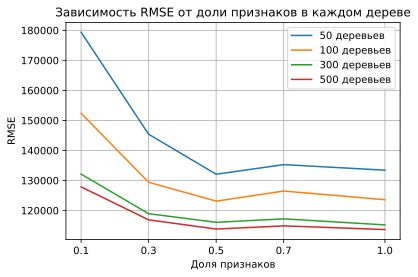

In [154]:
num_trees = [50, 100, 300, 500]
for n in num_trees:
    t = []
    for feat in feature_subsample:
        t.append(hyper_history_gb[4, feat, 0.1]['rmse_val'][n - 1])
    plt.plot(feature_subsample, t, label=f'{n} деревьев')
plt.grid()
plt.title('Зависимость RMSE от доли признаков в каждом дереве')
plt.legend()
plt.xticks(feature_subsample)
plt.ylabel('RMSE')
plt.xlabel('Доля признаков')
plt.savefig('pdf/gb_feat_rmse.pdf', bbox_inches='tight')

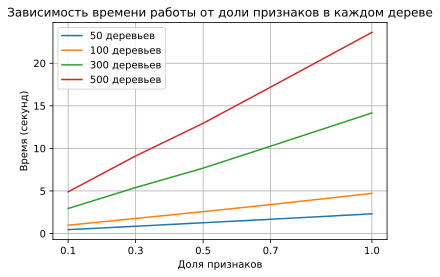

In [124]:
num_trees = [50, 100, 300, 500]
for n in num_trees:
    t = []
    for feat in feature_subsample:
        t.append(hyper_history_gb[4, feat, 0.1]['time'][n - 1])
    plt.plot(feature_subsample, t, label=f'{n} деревьев')
plt.grid()
plt.title('Зависимость времени работы от доли признаков в каждом дереве')
plt.legend()
plt.xticks(feature_subsample)
plt.ylabel('Время (секунд)')
plt.xlabel('Доля признаков')
plt.savefig('pdf/gb_feat_time.pdf', bbox_inches='tight')

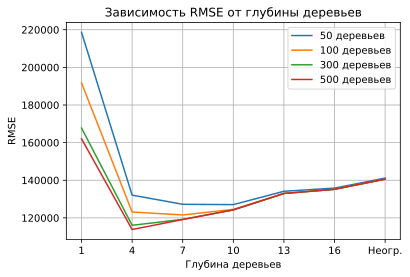

In [140]:
num_trees = [50, 100, 300, 500]
for n in num_trees:
    t = []
    for depth in max_depth:
        t.append(hyper_history_gb[depth, 0.5, 0.1]['rmse_val'][n - 1])
    plt.plot(max_depth[:-1] + [19], t, label=f'{n} деревьев')
plt.grid()
plt.xticks(max_depth[:-1] + [19], labels=max_depth[:-1] + ['Неогр.'])
plt.title('Зависимость RMSE от глубины деревьев')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Глубина деревьев')
plt.savefig('pdf/gb_depth_rmse.pdf', bbox_inches='tight')

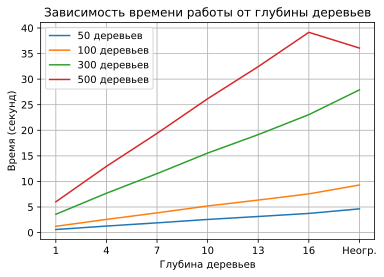

In [145]:
num_trees = [50, 100, 300, 500]
for n in num_trees:
    t = []
    for depth in max_depth:
        t.append(hyper_history_gb[depth, 0.5, 0.1]['time'][n - 1])
    plt.plot(max_depth[:-1] + [19], t, label=f'{n} деревьев')
plt.grid()
plt.xticks(max_depth[:-1] + [19], labels=max_depth[:-1] + ['Неогр.'])
plt.title('Зависимость времени работы от глубины деревьев')
plt.legend()
plt.ylabel('Время (секунд)')
plt.xlabel('Глубина деревьев')
plt.savefig('pdf/gb_depth_time.pdf', bbox_inches='tight')

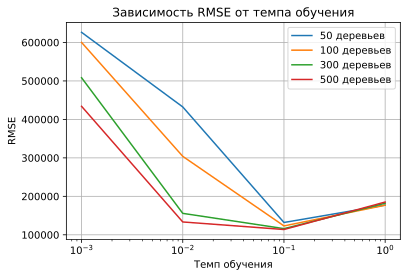

In [146]:
num_trees = [50, 100, 300, 500]
for n in num_trees:
    t = []
    for rate in learning_rate:
        t.append(hyper_history_gb[4, 0.5, rate]['rmse_val'][n - 1])
    plt.plot(learning_rate, t, label=f'{n} деревьев')
plt.grid()
plt.xticks(learning_rate)
plt.title('Зависимость RMSE от темпа обучения')
plt.legend()
plt.xscale('log')
plt.ylabel('RMSE')
plt.xlabel('Темп обучения')
plt.savefig('pdf/gb_rate_rmse.pdf', bbox_inches='tight')

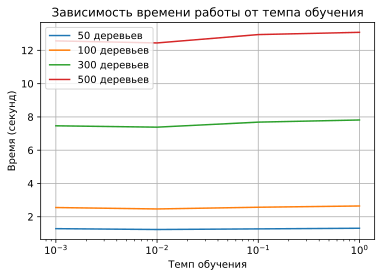

In [147]:
num_trees = [50, 100, 300, 500]
for n in num_trees:
    t = []
    for rate in learning_rate:
        t.append(hyper_history_gb[4, 0.5, rate]['time'][n - 1])
    plt.plot(learning_rate, t, label=f'{n} деревьев')
plt.grid()
plt.xticks(learning_rate)
plt.title('Зависимость времени работы от темпа обучения')
plt.xscale('log')
plt.legend(loc=2)
plt.ylabel('Время (секунд)')
plt.xlabel('Темп обучения')
plt.savefig('pdf/gb_rate_time.pdf', bbox_inches='tight')

In [154]:
%store hyper_history

Stored 'hyper_history' (dict)


In [155]:
%store hyper_history_gb

Stored 'hyper_history_gb' (dict)
